# Experiments

In those notebook, we will try to use multiple models on the data and report classification results!mm

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

### Hyperparameters


In [13]:
test_train_ratio = 0.3

### Download and Read Data

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.1 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=f2fe979506d27418c747c7afd1e1fe37855625098f1c8fd79a4388c12e2c1793
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
import contextlib
from google.colab import files
import io

with contextlib.redirect_stdout(io.StringIO()):
    files.upload()

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

! unzip /content/fake-and-real-news-dataset.zip -d data

 81% 33.0M/41.0M [00:00<00:00, 123MB/s] 
100% 41.0M/41.0M [00:00<00:00, 127MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: data/Fake.csv           
  inflating: data/True.csv           


In [6]:
fake_data = pd.read_csv('/content/data/Fake.csv')
true_data = pd.read_csv('/content/data/True.csv')

### Data Preparation

1. Assign Label 0,1 to True and Fake datasets
2. Combine True and Fake Datasets
3. Train-Test split using stratified sampling

In [7]:
fake_data['Label'] = 1
true_data['Label'] = 0

In [8]:
data = fake_data.append(true_data)

X = data['text'].values
y = data['Label'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=test_train_ratio)

In [15]:
print('Total no. of training examples : ', len(X_train))
print('Total no. of testing examples : ', len(X_test))

print('Label Distribution in training Data : ', Counter(y_train))
print('Label Distribution in testing Data : ', Counter(y_test))

Total no. of training examples :  31428
Total no. of testing examples :  13470
Label Distribution in training Data :  Counter({1: 16436, 0: 14992})
Label Distribution in testing Data :  Counter({1: 7045, 0: 6425})


## Experiment 2 : Support Vector Machines

### Training, Evaluation and Classification report

Use the structure already implemented to train NB Classifier

Accuracy : 97.7%
Classification Report : 

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6425
           1       0.98      0.97      0.98      7045

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470

************************************************************


Classification Confusion Matrix : 



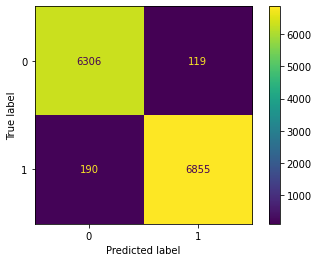

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

# Fit the pipeline on training data
text_clf.fit(X_train, y_train)

# Run the trained pipeline on test data
predicted = text_clf.predict(X_test)
# Get the accuracy
print("Accuracy : {:.1%}".format(np.mean(predicted == y_test)))

# Print the classification report
print('Classification Report : \n')
print(metrics.classification_report(y_test, predicted))
print('*'*60)
print('\n')
# Print Confusion matrix
print('Classification Confusion Matrix : \n')
cm = confusion_matrix(y_test, predicted)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot();

## Experiment 2 : Cross validated Grid Search

Perform Grid Search on various hyperparams of Random Forest

clf__criterion: 'entropy'
clf__max_depth: 8
clf__n_estimators: 500
************************************************************


Accuracy : 97.7%
************************************************************


Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6425
           1       0.97      0.98      0.98      7045

    accuracy                           0.98     13470
   macro avg       0.98      0.98      0.98     13470
weighted avg       0.98      0.98      0.98     13470

************************************************************


Classification Confusion Matrix : 



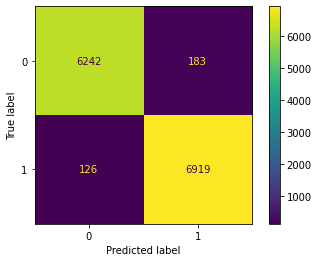

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])

# Define Parameter Grid
param_grid = {
    "clf__n_estimators": [200, 500],
    "clf__max_depth": [4, 5, 8],
    "clf__criterion": ["gini", "entropy"],
}

# Initialize Grid Search Classifier
# Obviously, such an exhaustive search can be expensive. 
# If we have multiple CPU cores at our disposal, we can tell the grid searcher to try these parameter combinations in parallel
#  with the n_jobs parameter. If we give this parameter a value of -1, 
# grid search will detect how many cores are installed and use them all
grid_search = GridSearchCV(text_clf, param_grid=param_grid, cv=5, n_jobs=-1)
# Train GS classifier
gs_clf = grid_search.fit(X_train, y_train)

# Access the model with the best score
gs_clf.best_score_
# Access the parameters with the best score
for param_name in sorted(param_grid.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print('*'*60)
print('\n')

# Run the trained pipeline on test data
predicted = gs_clf.predict(X_test)
# Get the accuracy
print("Accuracy : {:.1%}".format(np.mean(predicted == y_test)))
print('*'*60)
print('\n')
# Print the classification report
print('Classification Report : \n')
print(metrics.classification_report(y_test, predicted))
print('*'*60)
print('\n')
# Print Confusion matrix
print('Classification Confusion Matrix : \n')
cm = confusion_matrix(y_test, predicted)
cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot();

Similar performance as the SVM Classifier, but more resource intensive process due to multiple trainable models

